## load data and change into h5 files

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import Cooking
import random

In [2]:
RAW_DATA_DIR = 'record/'
COOKED_DATA_DIR = 'data_cooked/'
FIGURE_SIZE = (10,10)
# # The folders to search for data under RAW_DATA_DIR
# # For example, the first folder searched will be RAW_DATA_DIR/normal_1
# DATA_FOLDERS = ['normal_1', 'normal_2', 'normal_3', 'normal_4', 'normal_5', 'normal_6', 'swerve_1', 'swerve_2', 'swerve_3']

In [3]:
data_path = os.path.join(RAW_DATA_DIR, 'airsim_rec.txt')
dataset = pd.read_csv(data_path, sep='\t')
dataset.head()

,VehicleName,TimeStamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,Throttle,Steering,Brake,Gear,Handbrake,RPM,Speed,ImageFile
0,PhysXCar,1714287701008,0.000440,-0.007159,0.211444,0.864347,0.001259,-0.053815,0.500006,0,0,0,1,0,259.549,0.548739,img_PhysXCar__0_1714287701007505300.png
1,PhysXCar,1714287701081,0.013284,0.013632,0.210152,0.864289,0.004762,-0.053954,0.500070,0,0,0,1,0,221.530,0.520051,img_PhysXCar__0_1714287701080899400.png
2,PhysXCar,1714287701132,0.031849,0.045602,0.216839,0.863908,0.005136,-0.052644,0.500864,1,0,0,1,0,231.146,0.584190,img_PhysXCar__0_1714287701131623400.png
3,PhysXCar,1714287701184,0.047607,0.072840,0.220432,0.863809,0.004364,-0.052508,0.501056,1,0,0,1,0,319.164,0.613036,img_PhysXCar__0_1714287701184046200.png
4,PhysXCar,1714287701219,0.058290,0.091331,0.222274,0.863739,0.004156,-0.052763,0.501153,1,0,0,1,0,409.095,0.649084,img_PhysXCar__0_1714287701218411600.png


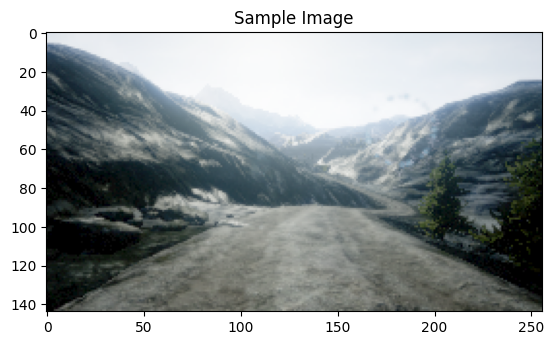

In [4]:
sample_image_path = os.path.join(RAW_DATA_DIR, 'images/img_PhysXCar__0_1714287701007505300.png')
sample_image = Image.open(sample_image_path)
plt.title('Sample Image')
plt.imshow(sample_image)
plt.show()

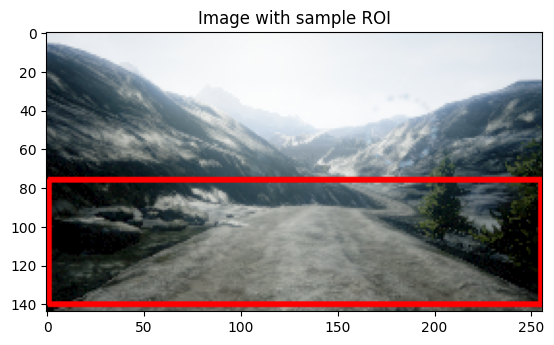

In [6]:
sample_image_roi = sample_image.copy()

fillcolor=(255,0,0)
draw = ImageDraw.Draw(sample_image_roi)
points = [(1,76), (1,140), (255,140), (255,76)]
for i in range(0, len(points), 1):
    draw.line([points[i], points[(i+1)%len(points)]], fill=fillcolor, width=3)
del draw

plt.title('Image with sample ROI')
plt.imshow(sample_image_roi)
plt.show()

In [7]:
# bins = np.arange(-1, 1.05, 0.05)

# plt.figure(figsize=(5, 5))
# plt.hist(dataset['Throttle'], bins)
# plt.xlabel('Steering Angle')
# plt.ylabel('Normalized Frequency')
# plt.show()

In [8]:
train_eval_test_split = [0.7, 0.2, 0.1]
full_path_raw_folders = [RAW_DATA_DIR]
Cooking.cook(full_path_raw_folders, COOKED_DATA_DIR, train_eval_test_split)

Preprocessed data already exists at: data_cooked/. Skipping preprocessing.


## Preprocess data

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from Generator import DriveDataGenerator
from keras.preprocessing import image
import keras.backend as K
import math

MODEL_OUTPUT_DIR = 'model'

In [10]:
train_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'train.h5'), 'r')
eval_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'eval.h5'), 'r')
test_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'test.h5'), 'r')

num_train_examples = train_dataset['image'].shape[0]
num_eval_examples = eval_dataset['image'].shape[0]
num_test_examples = test_dataset['image'].shape[0]

batch_size=32

In [25]:
data_generator = DriveDataGenerator(rescale=1./255., horizontal_flip=True, brightness_range=(0.6, 1.4))
train_generator = data_generator.flow\
    (train_dataset['image'], train_dataset['previous_state'], train_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[65,140,0,255])
eval_generator = data_generator.flow\
    (eval_dataset['image'], eval_dataset['previous_state'], eval_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[65,140,0,255])  

Actual Steering Angle = [0.66666667]


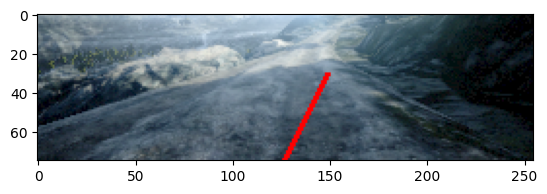

Actual Steering Angle = [-0.33333333]


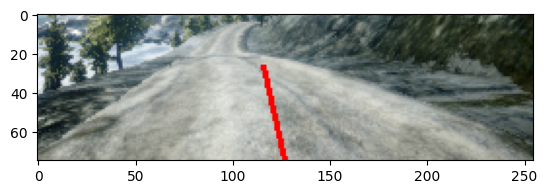

Actual Steering Angle = [0.33333333]


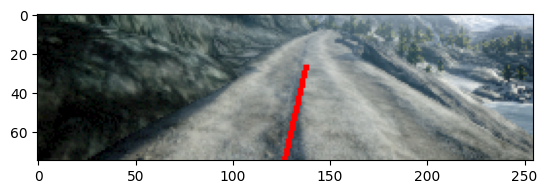

In [26]:

def draw_image_with_label(img, label, prediction=None):
    theta = label * 0.69 #Steering range for the car is +- 40 degrees -> 0.69 radians
    line_length = 50
    line_thickness = 3
    label_line_color = (255, 0, 0)
    prediction_line_color = (0, 0, 255)
    pil_image = image.array_to_img(img, K.image_data_format(), scale=True)
    print('Actual Steering Angle = {0}'.format(label))
    draw_image = pil_image.copy()
    image_draw = ImageDraw.Draw(draw_image)
    first_point = (int(img.shape[1]/2),img.shape[0])
    second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
    image_draw.line([first_point, second_point], fill=label_line_color, width=line_thickness)
    
    if (prediction is not None):
        print('Predicted Steering Angle = {0}'.format(prediction))
        print('L1 Error: {0}'.format(abs(prediction-label)))
        theta = prediction * 0.69
        second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
        image_draw.line([first_point, second_point], fill=prediction_line_color, width=line_thickness)
    
    del image_draw
    plt.imshow(draw_image)
    plt.show()

[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
for i in range(0, 3, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i])

## Train with Kera

In [47]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Input, concatenate
from keras.layers import BatchNormalization
from tensorflow.keras.layers import ELU
from keras.optimizers import Adam, SGD, Adamax, Nadam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping, ProgbarLogger

In [35]:
image_input_shape = sample_batch_train_data[0].shape[1:]
state_input_shape = sample_batch_train_data[1].shape[1:]
activation = 'relu'

#Create the convolutional stacks
pic_input = Input(shape=image_input_shape)

img_stack = Conv2D(16, (3, 3), name="convolution0", padding='same', activation=activation)(pic_input)
img_stack = MaxPooling2D(pool_size=(2,2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution1')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution2')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Flatten()(img_stack)
img_stack = Dropout(0.2)(img_stack)

#Inject the state input
state_input = Input(shape=state_input_shape)
merged = concatenate([img_stack, state_input])

# Add a few dense layers to finish the model
merged = Dense(64, activation=activation, name='dense0')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10, activation=activation, name='dense2')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1, name='output')(merged)

adam = Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model = Model(inputs=[pic_input, state_input], outputs=merged)
model.compile(optimizer=adam, loss='mse')

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 75, 255, 3)]         0         []                            
                                                                                                  
 convolution0 (Conv2D)       (None, 75, 255, 16)          448       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 37, 127, 16)          0         ['convolution0[0][0]']        
 g2D)                                                                                             
                                                                                                  
 convolution1 (Conv2D)       (None, 37, 127, 32)          4640      ['max_pooling2d_3[0][0]'

In [43]:
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', '{epoch:02d}', '{val_loss:.7f}'))
Cooking.checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback, ProgbarLogger()]

In [45]:
history = model.fit(train_generator, steps_per_epoch=num_train_examples//batch_size, epochs=100, callbacks=callbacks,\
                   validation_data=eval_generator, validation_steps=num_eval_examples//batch_size, verbose=2)

Epoch 1/100

Epoch 1: val_loss improved from 0.24205 to 0.20311, saving model to model/models/model_model.01-0.2031089.h5
63/63 - 7s - loss: 0.2299 - val_loss: 0.2031 - lr: 1.0000e-04 - 7s/epoch - 107ms/sample
Epoch 2/100

Epoch 2: val_loss improved from 0.20311 to 0.17577, saving model to model/models/model_model.02-0.1757651.h5
63/63 - 7s - loss: 0.2093 - val_loss: 0.1758 - lr: 1.0000e-04 - 7s/epoch - 104ms/sample
Epoch 3/100

Epoch 3: val_loss improved from 0.17577 to 0.16886, saving model to model/models/model_model.03-0.1688642.h5
63/63 - 7s - loss: 0.1969 - val_loss: 0.1689 - lr: 1.0000e-04 - 7s/epoch - 104ms/sample
Epoch 4/100

Epoch 4: val_loss did not improve from 0.16886
63/63 - 6s - loss: 0.1987 - val_loss: 0.1695 - lr: 1.0000e-04 - 6s/epoch - 102ms/sample
Epoch 5/100

Epoch 5: val_loss improved from 0.16886 to 0.14839, saving model to model/models/model_model.05-0.1483854.h5
63/63 - 6s - loss: 0.1860 - val_loss: 0.1484 - lr: 1.0000e-04 - 6s/epoch - 102ms/sample
Epoch 6/100


1/1 [==============================] - 0s 43ms/step
Actual Steering Angle = [-0.]
Predicted Steering Angle = [-0.50686014]
L1 Error: [0.50686014]


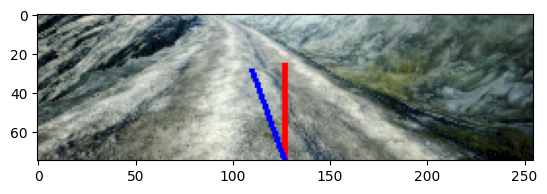

Actual Steering Angle = [0.66666667]
Predicted Steering Angle = [0.5133787]
L1 Error: [0.15328799]


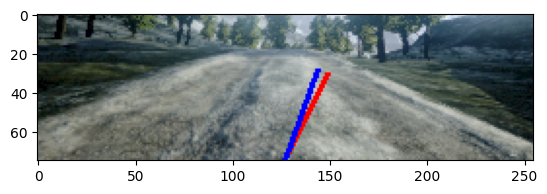

Actual Steering Angle = [1.]
Predicted Steering Angle = [0.74618626]
L1 Error: [0.25381374]


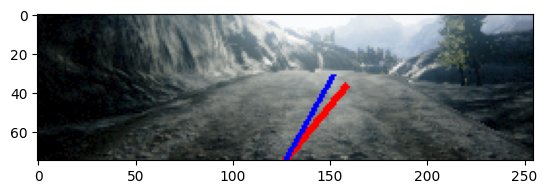

In [48]:
[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
predictions = model.predict([sample_batch_train_data[0], sample_batch_train_data[1]])
for i in range(5, 8, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i], predictions[i])

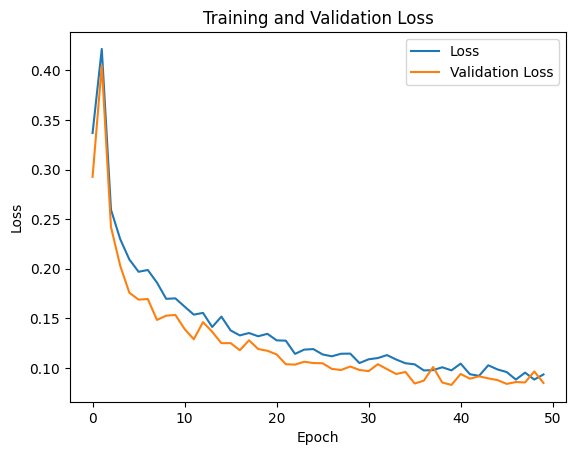

In [49]:
df_loss = pd.read_csv(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))

# Extract the 'loss' and 'val_loss' columns
train_loss = df_loss['loss']
val_loss = df_loss['val_loss']

# Plot the data
plt.plot(train_loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Test performace